In [ ]:
import pandas as pd
import re

# Load Kaggle dataset with proper data types
# Set low_memory=False to avoid DtypeWarning
restaurants_df = pd.read_csv("restaurants_dataset.csv", low_memory=False)

# Remove unnecessary columns
columns_to_remove = ['Images', 'Phone', 'Website', 'Time_Zone', 'Link','Geo_Coordinates','Latitude','Longitude']
restaurants_df = restaurants_df.drop(columns=columns_to_remove, errors='ignore')

# 1. Filter US-only data
restaurants_df = restaurants_df[restaurants_df["Address"].str.contains("United States|USA|US", case=False, na=False)]

restaurants_df = restaurants_df.copy()

# 2. Drop rows with missing critical values
restaurants_df.dropna(subset=["Address", "Rating"], inplace=True)

# 3. Convert Rating to float (handle any non-numeric values)
restaurants_df["Rating"] = pd.to_numeric(restaurants_df["Rating"], errors='coerce')

# 4. Extract ZIP codes
def extract_zip(address):
    zip_match = re.search(r'\b\d{5}\b', str(address))
    return zip_match.group(0) if zip_match else None

# Create new "ZCTA" column
restaurants_df["ZCTA"] = restaurants_df["Address"].apply(extract_zip)

# 5. Clean the data
# Remove rows with invalid/missing ZIP codes
restaurants_df = restaurants_df[restaurants_df["ZCTA"].notna()]

# Remove duplicate restaurants
restaurants_df = restaurants_df.drop_duplicates(subset=["Title", "Address"], keep="first")

# Save cleaned data
restaurants_df.to_csv("cleaned_restaurants.csv", index=False)

print(f"Total restaurants after cleaning: {len(restaurants_df)}")
print(f"Average rating: {restaurants_df['Rating'].mean():.2f}")
print(f"Number of unique ZCTAs: {restaurants_df['ZCTA'].nunique()}")
print(restaurants_df.head())

Total restaurants after cleaning: 140987
Average rating: 4.27
Number of unique ZCTAs: 10438
                          Title              Category  Rating  \
0     Dairy Queen Grill & Chill  Fast food restaurant     3.8   
1             Jake's Restaurant   American restaurant     4.4   
2                 Carib Kitchen  Caribbean restaurant     4.9   
3  Cazadores Mexican Restaurant    Mexican restaurant     4.5   
4       La Posada Mexican Grill    Mexican restaurant     4.3   

                                             Address  \
0  Dairy Queen Grill & Chill, 3143 US-280, Alexan...   
1  Jake's Restaurant, 16 Broad St, Alexander City...   
2  Carib Kitchen, 68 Broad St, Alexander City, AL...   
3  Cazadores Mexican Restaurant, 910 Cherokee Rd,...   
4  La Posada Mexican Grill, 3714 US-280, Alexande...   

                                          Categories   ZCTA  
0         ['Fast food restaurant', 'Ice cream shop']  35010  
1                            ['American restaurant']  35

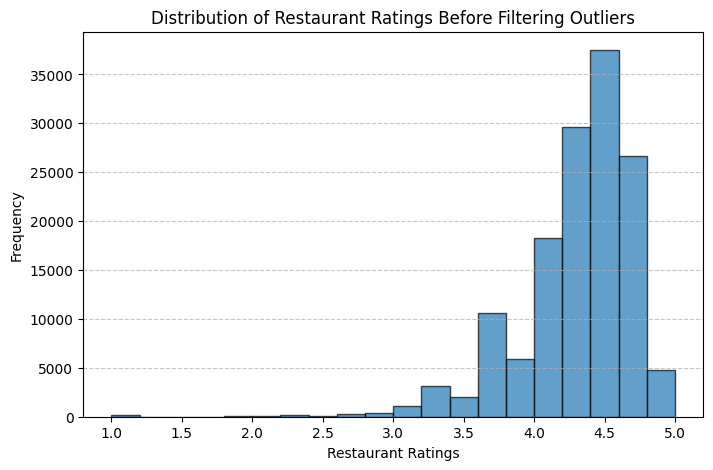

Outlier ratings removed. Cleaned dataset saved as 'filtered_restaurants.csv'.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
file_path = "cleaned_restaurants.csv"
restaurants_df = pd.read_csv(file_path)

# Plot distribution of ratings before filtering outliers
plt.figure(figsize=(8, 5))
plt.hist(restaurants_df["Rating"], bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Restaurant Ratings")
plt.ylabel("Frequency")
plt.title("Distribution of Restaurant Ratings Before Filtering Outliers")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Remove outlier ratings
restaurants_df = restaurants_df[(restaurants_df["Rating"] >= 1.0) & (restaurants_df["Rating"] <= 5.0)]

# Save the cleaned dataset again
restaurants_df.to_csv("filtered_restaurants.csv", index=False)

print("Outlier ratings removed. Cleaned dataset saved as 'filtered_restaurants.csv'.")


In [ ]:
import requests
import pandas as pd

url = "https://api.census.gov/data/2022/acs/acs5"

params={
        "get": "NAME,B19013_001E,B01003_001E,B01001_007E,B01001_011E,B01001_021E,B01001_031E,B01001_035E,B01001_045E,B03002_006E,B04004_005E,B03003_003E",
        "for": "zip code tabulation area:*",     # Get ALL ZCTAs
}

response = requests.get(url, params=params)
# Convert response to DataFrame
data = response.json()
columns = data[0]
census_df = pd.DataFrame(data[1:], columns=columns)

# Clean and rename columns
census_df = census_df.rename(columns={
    "B19013_001E": "Median_Income",
    "B01003_001E": "Population",
    "B01001_007E": "Males_20yrs_age",
    "B01001_011E": "Males_30yrs_age",
    "B01001_021E": "Males_60yrs_age",
    "B01001_031E": "Females_20yrs_age",
    "B01001_035E": "Females_30yrs_age",
    "B01001_045E": "Females_60yrs_age",
    "B03002_006E": "Asian",
    "B04004_005E": "American",
    "B03003_003E": "Hispanic_or_Latino",
    "zip code tabulation area": "ZCTA"
})

# Handle missing data codes
census_df.replace("-666666666", pd.NA, inplace=True)

# Convert numeric columns
census_df["Median_Income"] = pd.to_numeric(census_df["Median_Income"])
census_df["Population"] = pd.to_numeric(census_df["Population"])
census_df["ZCTA"] = census_df["ZCTA"].astype(str).str.zfill(5)
census_df["Males_20yrs_age"] = pd.to_numeric(census_df["Males_20yrs_age"])
census_df["Males_30yrs_age"] = pd.to_numeric(census_df["Males_30yrs_age"])
census_df["Males_60yrs_age"] = pd.to_numeric(census_df["Males_60yrs_age"])
census_df["Females_20yrs_age"] = pd.to_numeric(census_df["Females_20yrs_age"])
census_df["Females_30yrs_age"] = pd.to_numeric(census_df["Females_30yrs_age"])
census_df["Females_60yrs_age"] = pd.to_numeric(census_df["Females_60yrs_age"])
#census_df["Asian"] = pd.to_numeric(census_df["Asian"])
#census_df["American"] = pd.to_numeric(census_df["American"])
#census_df["Hispanic_or_Latino"] = pd.to_numeric(census_df["Hispanic_or_Latino"])

# Save to CSV
census_df.to_csv("all_zcta_demographics.csv", index=False)

print(f"Success! Saved {len(census_df)} ZCTAs to CSV.")
print(census_df.head())

Success! Saved 33774 ZCTAs to CSV.
          NAME  Median_Income  Population  Males_20yrs_age  Males_30yrs_age  \
0  ZCTA5 00601        17526.0       16834              233              534   
1  ZCTA5 00602        20260.0       37642              448             1275   
2  ZCTA5 00603        17703.0       49075              712             1706   
3  ZCTA5 00606        19603.0        5590               59               99   
4  ZCTA5 00610        22796.0       25542              305              899   

   Males_60yrs_age  Females_20yrs_age  Females_30yrs_age  Females_60yrs_age  \
0              352                191                475                298   
1              738                416               1224                670   
2              757                621               1377                854   
3               90                 99                136                140   
4              481                261                836                525   

  Asian America

In [ ]:
# Load cleaned datasets
restaurants_df = pd.read_csv("filtered_restaurants.csv")
census_df = pd.read_csv("all_zcta_demographics.csv")

# Ensure ZCTA columns are the same type (string)
restaurants_df["ZCTA"] = restaurants_df["ZCTA"].astype(str)
census_df["ZCTA"] = census_df["ZCTA"].astype(str)

# Merge datasets
merged_df = pd.merge(
    restaurants_df,
    census_df,
    on="ZCTA",
    how="left"  # Keep all restaurants, even if Census data is missing
)

# Drop rows with missing Census data
merged_df.dropna(subset=["Median_Income", "Population","Males_20yrs_age","Males_30yrs_age","Males_60yrs_age","Females_20yrs_age","Females_30yrs_age","Females_60yrs_age"], inplace=True)

# Save merged dataset
merged_df.to_csv("merged_restaurants_census.csv", index=False)
print(merged_df.head())

                          Title              Category  Rating  \
0     Dairy Queen Grill & Chill  Fast food restaurant     3.8   
1             Jake's Restaurant   American restaurant     4.4   
2                 Carib Kitchen  Caribbean restaurant     4.9   
3  Cazadores Mexican Restaurant    Mexican restaurant     4.5   
4       La Posada Mexican Grill    Mexican restaurant     4.3   

                                             Address  \
0  Dairy Queen Grill & Chill, 3143 US-280, Alexan...   
1  Jake's Restaurant, 16 Broad St, Alexander City...   
2  Carib Kitchen, 68 Broad St, Alexander City, AL...   
3  Cazadores Mexican Restaurant, 910 Cherokee Rd,...   
4  La Posada Mexican Grill, 3714 US-280, Alexande...   

                                          Categories   ZCTA         NAME  \
0         ['Fast food restaurant', 'Ice cream shop']  35010  ZCTA5 35010   
1                            ['American restaurant']  35010  ZCTA5 35010   
2                           ['Caribbean rest